In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from auxiliary.visualization import visualize_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name
from model_components.unet import *
from model_components.resunet import *
from model_components.attunet import *
from model_components.vit import *

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    # local path
    raster_path = "../data.nosync/raster"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"

print(f"Device set to: {device}")

Device set to: mps


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

### Loading the data

In [6]:
# Setting up a Dataset object for DataLoader
class BuildingRasterDataset(Dataset):
    def __init__(self, path, operators, attach_roads=True, transform=None):
        '''Stores the directory and filenames of the individual .npz files.'''
        # store directory of individual files
        self.path = path
        # get filenames of individual files
        #self.filenames = [file for file in os.listdir(path) if file.endswith(".npz")]
        # for testing purposes: take only the first 1000 files
        self.filenames = [file for file in os.listdir(path) if file.endswith(".npz")][:1000]

        # store indices of the operators within operator_order for slicing in the .__getitem__() method
        self.operators = operators

        # store information on whether roads should be attached
        self.attach_roads = attach_roads

        # store transformation
        self.transform = transform

    def __len__(self):
        '''Enables dataset length calculation.'''
        return len(self.filenames)

    def __getitem__(self, index):
        '''Enables indexing, returns block raster as features and generalization operators as label.'''
        # get filename associated with given index
        filename = self.filenames[index]

        # load the file with the filename
        sample = np.load(os.path.join(self.path, filename))

        # extract the rasters
        focal_building = sample["focal_building"]
        context_buildings = sample["context_buildings"]
        roads = sample["roads"]

        # stack the rasters according to attach_roads
        if self.attach_roads:
            # stack the rasters to shape (3, n_pixels, n_pixels)
            block = np.stack([focal_building, context_buildings, roads], axis=0)
        else:
            # leave out the roads, stack the rasters to shape (2, n_pixels, n_pixels)
            block = np.stack([focal_building, context_buildings], axis=0)

        # convert rasters to tensor
        block = torch.from_numpy(block).float()

        if self.transform:
            block = self.transform(block)

        # collect labels according to specified generalization operators
        operators = [torch.from_numpy(sample[operator]).float() for operator in self.operators]

        # stack the operators to a tensor
        operators = torch.stack(operators, dim=0).float()

        return block, operators

### Training pipeline

1) Design model (input, output size, forward pass)
2) Construct loss and optimizer
3) Training loop
     * Forward pass: Compute prediction
     * Backward pass: Compute gradients
     * Update weights

### Model design

Stride refers to the number of positions that the convolutional kernel shifts at one step. Input channel size of one layer should always be equal to the output channel size of the previous layer.

The application of convolution and pooling layers decreases the size of the image: The output after a convolution can be calculated according to the following formula, where $W$ is the input width, $F$ is the kernel size, $P$ is the padding and $S$ is the stride:

$$\frac{(W-F + 2 P)}{S} + 1$$

In [7]:
# Classification head with global average pooling and fully-connected layers
class ClassificationHeadGAP(nn.Module):
    def __init__(self, n_input_features, n_classes):
        super(ClassificationHeadGAP, self).__init__()
        
        # Due to the global average pooling, the number of input features corresponds to the number of output channels of the last
        # convolutional layers
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)), # averaging output feature across spatial dimensions resulting in single feature vector
            nn.Flatten(), # flatten to reshape the tensor from 4D to 2D
            nn.Dropout(0.5), # reduce overfitting, rate typically between 0.3 and 0.5
            nn.Linear(in_features=n_input_features, out_features=512), # intermediate fully-connected layer for classification
            nn.ReLU(inplace=True), # rectified linear unit activation function
            nn.Linear(in_features=512, out_features=n_classes) # final fully-connected layer with one neuron per class to predicted
        )

    def forward(self, x):
        return self.fc(x)

# Classification head with fully-connected layers without global average pooling
class ClassificationHeadFC(nn.Module):
    def __init__(self, n_input_features, n_classes):
        super(ClassificationHeadFC, self).__init__()
        
        # the number of input features of first fully-connected layer are calculated by multiplying number of output channels of last 
        # convolutional layer by (image size after all pooling operations)^2
        # the last fully-connected layer has six output neurons, one for each generalization operator
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=n_input_features, out_features=16),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=16, out_features=n_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [8]:
# conventional, simple CNN
class CNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # appending classification head
        #self.classification_head = ClassificationHeadGAP(n_input_features=128, n_classes=n_classes)
        self.classification_head = ClassificationHeadFC(n_input_features=128*32*32, n_classes=n_classes)

    def forward(self, x):
        # input dimension = 256
        x = self.pool(F.relu(self.conv1(x)))
        # input dimension = 128
        x = self.pool(F.relu(self.conv2(x)))
        # input dimension = 64
        x = self.pool(F.relu(self.conv3(x)))
        # input dimension = 32
        x = self.classification_head(x) # No sigmoid function necessary, since BCEWithLogitsLoss applies sigmoid internally for loss computation

        return x

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"CNN with {self.get_n_parameters():,} parameters"

class MultiTaskCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(MultiTaskCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # appending a classification head for each class to be predicted
        self.classification_heads = nn.ModuleList([ClassificationHeadGAP(n_input_features=128, n_classes=1) for _ in range(n_classes)])
        #self.classification_heads = nn.ModuleList([ClassificationHeadFC(n_input_features=128*32*32, n_classes=1) for _ in range(n_classes)])

    def forward(self, x):
        # input dimension = 256
        x = self.pool(F.relu(self.conv1(x)))
        # input dimension = 128
        x = self.pool(F.relu(self.conv2(x)))
        # input dimension = 64
        x = self.pool(F.relu(self.conv3(x)))
        # input dimension = 32

        # apply each classification head and concatenate the results along the final dimension
        outputs = torch.cat([head(x).squeeze(-1).unsqueeze(1) for head in self.classification_heads], dim=1)

        return outputs

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"Multi-Task CNN with {self.get_n_parameters():,} parameters"    

# Code for U-net adapted from https://github.com/milesial/Pytorch-UNet
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, 1))

        # appending classification head
        self.classification_head = ClassificationHeadGAP(n_input_features=1, n_classes=n_classes)

    def forward(self, x):
        # encoding
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # decoding + concatenation
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        # passing the segmentation output through the classification head
        x = self.classification_head(logits)

        return x

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"U-Net with {self.get_n_parameters():,} parameters"

# Code for Residual U-net adapted from https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture
class ResUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(3, 64, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        #self.sigmoid = nn.Sigmoid() # sigmoid not necessary when using BCEWithLogitsLoss

        # appending classification head
        self.classification_head = ClassificationHeadGAP(n_input_features=1, n_classes=n_classes)

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        #output = self.sigmoid(output) # sigmoid not necessary when using BCEWithLogitsLoss

        # passing the segmentation output through the classification head
        output = self.classification_head(output)

        return output

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"Residual U-Net with {self.get_n_parameters():,} parameters"

# Code for Attention U-net adapted from https://github.com/LeeJunHyun/Image_Segmentation
class AttUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(AttUNet,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=n_channels,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,1,kernel_size=1,stride=1,padding=0)

        # appending classification head
        self.classification_head = ClassificationHeadGAP(n_input_features=1, n_classes=n_classes)

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        # passing the segmentation output through the classification head
        output = self.classification_head(d1)

        return output

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"Attention U-Net with {self.get_n_parameters():,} parameters"

# Code for Vision Transformer adapted from https://github.com/lucidrains/vit-pytorch
class ViT(nn.Module):
    def __init__(self, *, 
                 image_size=256, 
                 patch_size=32, 
                 num_classes, 
                 dim=512, 
                 depth=6, 
                 heads=16, 
                 mlp_dim=2048, 
                 pool='cls',
                 channels, 
                 dim_head=64, 
                 dropout=0., 
                 emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"Vision transformer with {self.get_n_parameters():,} parameters"

class MultiTaskViT(nn.Module):
    def __init__(self, *, 
                 image_size=256, 
                 patch_size=32, 
                 num_classes, 
                 dim=512, 
                 depth=6, 
                 heads=16, 
                 mlp_dim=2048, 
                 pool='cls',
                 channels, 
                 dim_head=64, 
                 dropout=0., 
                 emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.classification_heads = nn.ModuleList([nn.Linear(dim, 1) for _ in range(num_classes)])

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        
        # apply each classification head and concatenate the results along the final dimension
        outputs = torch.cat([head(x).squeeze(-1).unsqueeze(1) for head in self.classification_heads], dim=1)
        
        return outputs

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"Multi-Task Vision transformer with {self.get_n_parameters():,} parameters"

### Loss and activation function

Softmax is a common activation function, (binary) cross-Entropy is a common loss function for multiclass classification problems, sigmoid is commonly used for binary classification problems. When using the Pytorch implementation: no softmax in the last layer, class labels not one-hot encoded and no softmax. BCELoss requires an activation function at the end! Sigmoid are usually the last layers in binary classification probems.

If you don't know which activation function to use, just use ReLU, Leaky ReLU tries to adress vanishing gradient problem. Multiplies input with small negative numbers, as normal ReLU may cause many gradients to become zero, which means that the weights will never be updated. Whenever weights are not updated during training, use Leaky ReLU.

I am dealing with a multilabel (for each generalization operator), binary (operator present or absent) classification problem.

## Elimination model

In [9]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "elimination", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "elimination", "validation")

# define input parameters
elimination_operators = ["elimination"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(elimination_operators)

# Creating model and moving to device
#model = CNN(n_channels=n_channels, n_classes=n_classes)
model = MultiTaskCNN(n_channels=n_channels, n_classes=n_classes)
#model = ResUNet(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes)
#model = MultiTaskViT(channels=n_channels, num_classes=n_classes)

model.to(device)
print(f"Using {model}")

learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using Multi-Task CNN with 159,809 parameters


### Training loop

In [10]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training DataLoader
training_set = BuildingRasterDataset(path_to_training_data, operators=elimination_operators, attach_roads=attach_roads, transform=transform)
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no transformations, no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, operators=elimination_operators, attach_roads=attach_roads, transform=None)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, (block, operators) in enumerate(training_loader):
        n_training_batches += 1
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(block) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for block, operators in validation_loader:
            n_validation_batches += 1
            
            # moving the features to device
            block = block.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(block)
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

1,000 samples in the training set.
1,000 samples in the validation set.
epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.695, validation loss: 0.691
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.693, validation loss: 0.694
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.685, validation loss: 0.603
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4

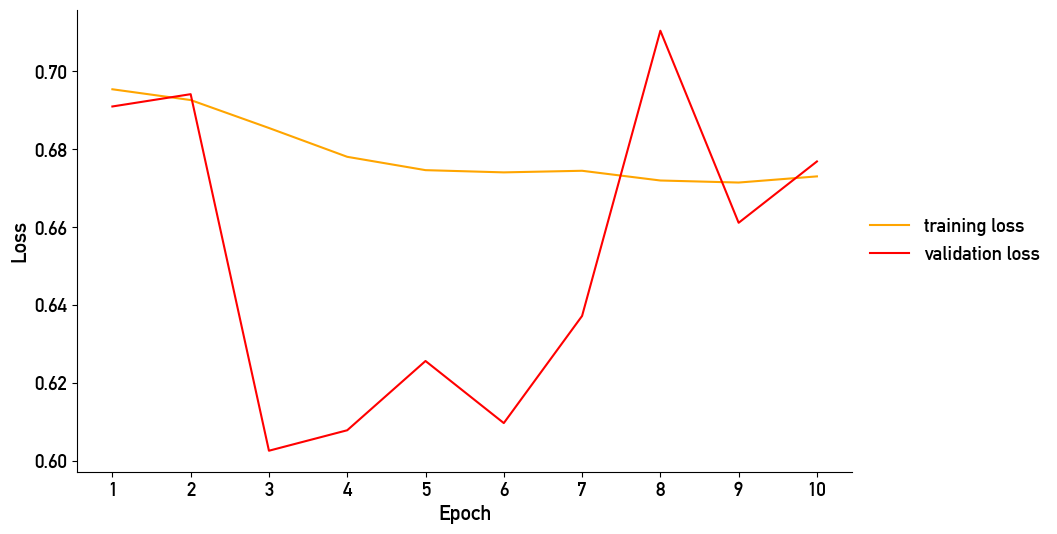

In [11]:
loss_path = os.path.join(raster_path, "model_outputs", "elimination", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

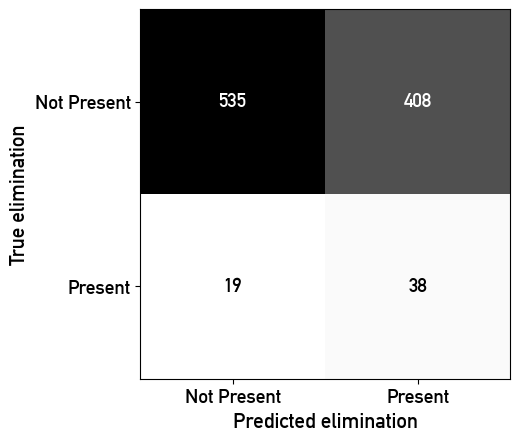

Accuracy: 0.573
Precision: 0.085
Recall: 0.667
F1 Score: 0.151


In [12]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch
true_elimination = []
pred_elimination = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for block, operators in validation_loader:
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(block)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # extracting true and predicted elimination
        true_elimination_batch = operators[:,0]
        pred_elimination_batch = pred_operators_labels[:,0]

        # collect data for metrics calculation
        true_elimination.append(true_elimination_batch.cpu())
        pred_elimination.append(pred_elimination_batch.cpu())

# convert lists to tensors
true_elimination = torch.cat(true_elimination)
pred_elimination = torch.cat(pred_elimination)

# calculate metrics
conf_matrix = confusion_matrix(true_elimination.numpy(), pred_elimination.numpy())
accuracy = accuracy_score(true_elimination.numpy(), pred_elimination.numpy())
precision = precision_score(true_elimination.numpy(), pred_elimination.numpy())
recall = recall_score(true_elimination.numpy(), pred_elimination.numpy())
f1 = f1_score(true_elimination.numpy(), pred_elimination.numpy())

# saving the accuracy metrics
model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame({"operator": ["elimination"],
                           "accuracy": [accuracy], 
                           "precision": [precision],
                           "recall": [recall],
                           "f1-score": [f1]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# display the confusion matrix
visualize_confusion_matrix(conf_matrix, operator="elimination")

# print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

### Saving the model

In [13]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "elimination")

model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

## Selection model

In [14]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "selection", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "selection", "validation")

# define input parameters
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(selection_operators)

# Creating model and moving to device
#model = CNN(n_channels=n_channels, n_classes=n_classes)
model = MultiTaskCNN(n_channels=n_channels, n_classes=n_classes)
#model = ResUNet(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes)
#model = MultiTaskViT(channels=n_channels, num_classes=n_classes)

model.to(device)
print(f"Using {model}")

learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using Multi-Task CNN with 359,492 parameters


### Training loop

In [15]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training DataLoader
training_set = BuildingRasterDataset(path_to_training_data, operators=selection_operators, attach_roads=attach_roads, transform=transform)
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no transformations, no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, operators=selection_operators, attach_roads=attach_roads, transform=None)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, (block, operators) in enumerate(training_loader):
        n_training_batches += 1
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(block) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for block, operators in validation_loader:
            n_validation_batches += 1
            
            # moving the features to device
            block = block.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(block)
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

1,000 samples in the training set.
1,000 samples in the validation set.
epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.687, validation loss: 0.643
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.684, validation loss: 0.633
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.663, validation loss: 0.639
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4

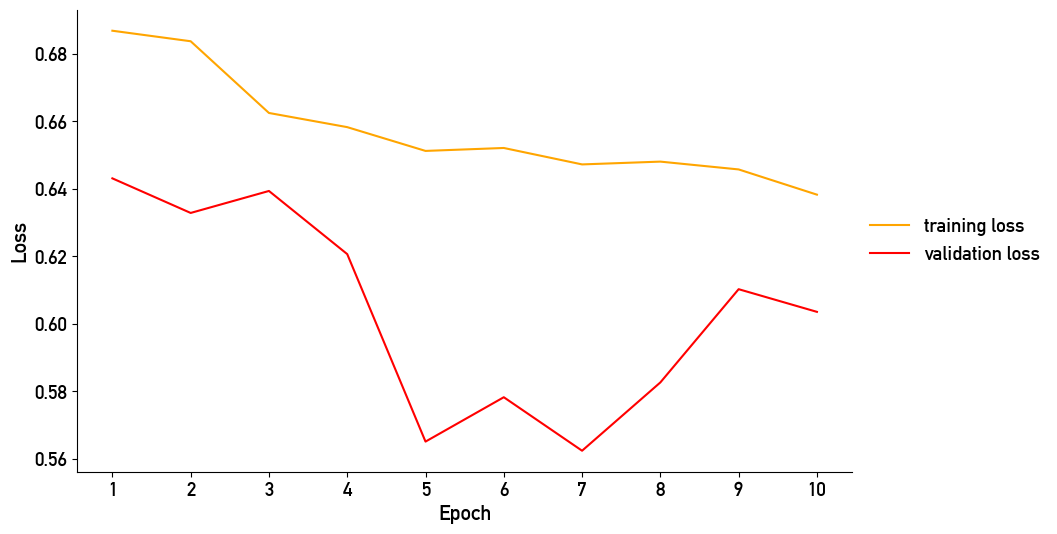

In [16]:
loss_path = os.path.join(raster_path, "model_outputs", "selection", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

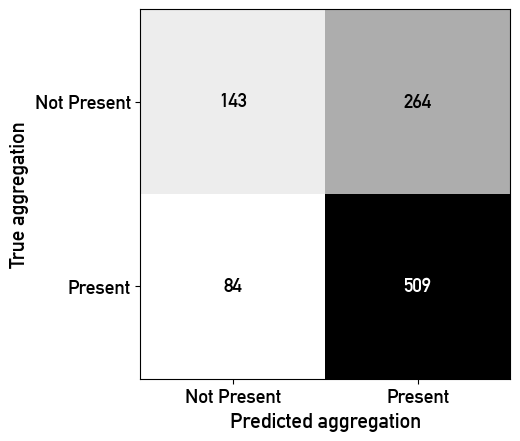

Accuracy: 0.652
Precision: 0.658
Recall: 0.858
F1 Score: 0.745


/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


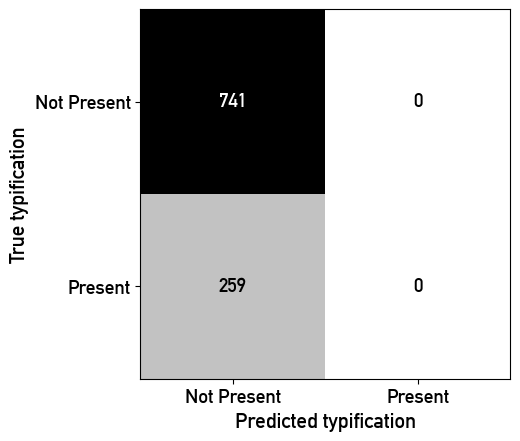

Accuracy: 0.741
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


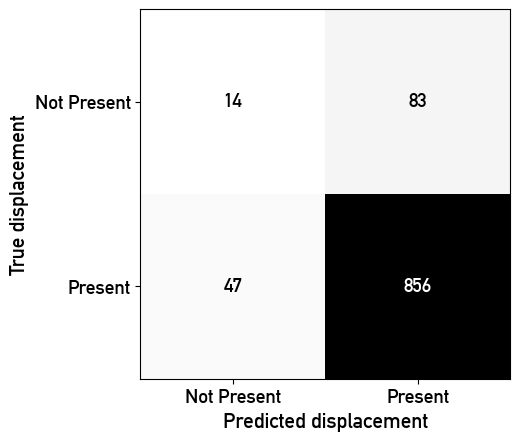

Accuracy: 0.870
Precision: 0.912
Recall: 0.948
F1 Score: 0.929


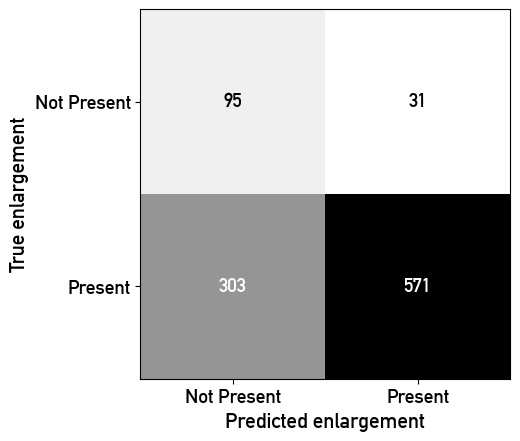

Accuracy: 0.666
Precision: 0.949
Recall: 0.653
F1 Score: 0.774


In [17]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch for every operator
true_operators_all = {}
pred_operators_all = {}

for operator_name in selection_operators:
    true_operators_all[operator_name] = []
    pred_operators_all[operator_name] = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for block, operators in validation_loader:
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(block)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # storing true labels and predictions for every operator
        for i, operator_name in enumerate(selection_operators):
            # extracting true and predicted operator
            true_operator_batch = operators[:,i]
            pred_operator_batch = pred_operators_labels[:,i]

            # collect data for metrics calculation
            true_operators_all[operator_name].append(true_operator_batch.cpu())
            pred_operators_all[operator_name].append(pred_operator_batch.cpu())

metrics = {"operator": [], 
           "accuracy": [], 
           "precision": [], 
           "recall": [], 
           "f1_score": []}

for operator_name in selection_operators:
    # convert lists to tensors
    cur_true_operator = torch.cat(true_operators_all[operator_name])
    cur_pred_operator = torch.cat(pred_operators_all[operator_name])

    # calculate metrics of the current operator
    conf_matrix = confusion_matrix(cur_true_operator.numpy(), cur_pred_operator.numpy())
    accuracy = accuracy_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    precision = precision_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    recall = recall_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    f1 = f1_score(cur_true_operator.numpy(), cur_pred_operator.numpy())

    # store the metrics of the current operator
    metrics["operator"].append(operator_name)
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

    # display the confusion matrix
    visualize_confusion_matrix(conf_matrix, operator=operator_name)
    
    # print metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

# saving the accuracy metrics
model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame(metrics)

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

### Saving the model

In [18]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "selection")

model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

### Ideas

* Investigate effect of building size on the prediction quality? Other "confounding" factors.
* See whether including the roads actually increases the prediction performance.
* Investigate effects of imbalanced data / operator distribution.